## Contents<a id='3.1_Contents'></a>
  * [3.1 Introduction](#3.1_Contents)
  * [3.2 Problem Statement](#2.2_Problem_statement)
  * [3.3 Data Wrangling](#3.3)
      * [3.3.1 Data Wrangling Summary](#3.3.1)
      * [3.3.2 Get the Data](#3.3.2)
      * [3.3.3 Explore the Data](#3.3.3)
      * [3.3.4 Transform the Data](#3.3.4)
  * [3.4 Exploratory Data Analysis](#3.4)
      * [3.4.1 Exploratory Data Analysis Summary](#3.4.1)
      * [3.4.2 Univariate Analysis](#3.4.2)
      * [3.4.3 Bivariate Analysis](#3.4.3)
      * [3.4.4 Correlation Analysis](#3.4.4)
      * [3.4.5 Temporal Analysis of Case Trends Over Time](#3.4.5)
      * [3.4.6 Text Analysis](#3.4.6)
      * [3.4.7 Case and Court Analysis](#3.4.7)
      * [3.4.8 Network Analysis of Cited Cases](#3.4.8)
      * [3.4.9 Analysis of Judges and Their Opinions](#3.4.9)

# 3.1 Introduction<a id='3.1_Introduction'></a>

Legal professionals are inundated with a vast array of complex documents, including contracts, case law, judicial opinions, and oral arguments. These documents require meticulous analysis and summarization to extract pertinent information, a process that is currently manual, time-consuming, and prone to errors. The SCOTUS dataset, containing a wealth of legal documents from the U.S. Supreme Court, presents an opportunity to apply Natural Language Processing (NLP) techniques to automate and enhance the analysis of these documents. By leveraging NLP, we aim to develop a system that can efficiently extract key information, summarise content, and classify documents based on their content, such as contract types or case law topics. This will not only save time but also increase the accuracy and consistency of legal document analysis.

# 3.2 Problem Statement<a id='3.2_Problem_statement'></a>

Can key information be automatically extracted from legal documents and can these documents be accurately classified and summarised using NLP techniques to aid legal professionals in their research and decision-making processes?

# 3.3 Data Wrangling<a id='3.3'></a>

## 3.3.1 Data Wrangling Summary<a id='3.3.1'></a>

In this step:

1) Imported json files and converted them into a dataframe. Converting the nested json structures were challenging so normalizing the columns with complicated structures separately. Also, calculating the load times just to plan the data import of files accordingly.
2) Explored data columns using head(), info(), shape,describe.
3) Cleansed data after we counted null values and unique values per column. Also removed all rows where found NaN in irrelevant columns, removed the columns with most of NaN value. a) Using casebody.Judges last value from the list if multiple values exist.
    b) Calculating the case_length using first_page and last_page, we had to convert the first_page and last_page to numeric values to perform this action.

## 3.3.2 Get the data<a id='3.3.2'></a>

In [4]:
import requests
import zipfile
import os
import json
import pandas as pd
import time


def expand_nested_columns(df):
    """
    Expands nested columns like citations and casebody.opinions, renames casebody.judges.
    
    Args:
        df (pd.DataFrame): DataFrame containing nested columns to expand.
        
    Returns:
        pd.DataFrame: DataFrame with expanded columns.
    """
    start_time = time.time()

    # Expand 'citations' column
    if 'citations' in df.columns:
        print("Expanding 'citations' column")
        
        # Ensure that 'citations' is a list of dictionaries
        if df['citations'].apply(lambda x: isinstance(x, list) and all(isinstance(i, dict) for i in x)).all():
            # Normalize 'citations' column
            # Explode lists if necessary
            df = df.explode('citations', ignore_index=True)
            citations_df = pd.json_normalize(df['citations'])
            citations_df.columns = [f'citations_{col}' for col in citations_df.columns]
            df = df.drop(columns=['citations']).join(citations_df)
        else:
            print("'citations' column data is not in expected format")
    
    # Expand 'casebody.opinions' and rename 'casebody.opinions.author' to 'casebody.judges'
    if 'casebody' in df.columns and 'casebody.opinions' in df.columns:
        print("Expanding 'casebody' column")
        
        casebody_opinions_df = pd.json_normalize(df['casebody.opinions'])
        casebody_opinions_df.columns = [f'casebody_opinions_{col}' for col in casebody_opinions_df.columns]
        df = df.join(casebody_opinions_df)
        
        # Rename 'casebody_opinions_author' to 'casebody_judges'
        if 'casebody_opinions_author' in casebody_opinions_df.columns:
            df.rename(columns={'casebody_opinions_author': 'casebody_judges'}, inplace=True)
        
        # Rename 'casebody.judges' to 'casebody_judges_old' if it exists
        if 'casebody.judges' in df.columns:
            df.rename(columns={'casebody.judges': 'casebody_judges_old'}, inplace=True)

        # Drop the original 'casebody' column after expansion
        df.drop(columns=['casebody'], inplace=True)

    end_time = time.time()
    print(f"Time taken to expand nested columns: {end_time - start_time:.2f} seconds")
    
    return df


def extract_scotus_data(dataset_numbers=range(180, 187), download_dir="datasets", extracted_dir="extracted_files"):
    """
    Extracts SCOTUS data from the given range of dataset numbers, downloads and extracts the files,
    and combines the data into a single DataFrame.
    
    Args:
        dataset_numbers (range): Range of dataset numbers to download.
        download_dir (str): Directory to store the downloaded files.
        extracted_dir (str): Directory to store the extracted files.
    
    Returns:
        pd.DataFrame: Combined DataFrame of all extracted data.
    """
    start_time = time.time()

    # Create directories if they don't exist
    os.makedirs(download_dir, exist_ok=True)
    os.makedirs(extracted_dir, exist_ok=True)

    # List to hold dataframes
    dataframes = []

    for num in dataset_numbers:
        # Download the file
        download_start_time = time.time()
        url = f'https://static.case.law/wash-2d/{num}.zip'
        local_zip_filename = os.path.join(download_dir, f'{num}.zip')

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_zip_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        download_end_time = time.time()
       # print(f"Downloaded file: {local_zip_filename} in {download_end_time - download_start_time:.2f} seconds")

        # Extract the contents of the zip file
        extract_start_time = time.time()
        with zipfile.ZipFile(local_zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)
        
        extract_end_time = time.time()
        #print(f"Extracted file: {local_zip_filename} in {extract_end_time - extract_start_time:.2f} seconds")

        # Read the content of each extracted JSON file
        load_start_time = time.time()
        for root, dirs, files in os.walk(extracted_dir):
            for file in files:
                if file.endswith(".json"):
                    file_path = os.path.join(root, file)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = json.load(f)
                        df = pd.json_normalize(content)
                        df = expand_nested_columns(df)
                        dataframes.append(df)
                    
                    print(f"Loaded JSON data from: {file_path}")

        load_end_time = time.time()
        #print(f"Time taken to load JSON data: {load_end_time - load_start_time:.2f} seconds")

    # Merge all dataframes into one
    merge_start_time = time.time()
    df = pd.concat(dataframes, ignore_index=True)
    merge_end_time = time.time()
    print(f"Time taken to merge dataframes: {merge_end_time - merge_start_time:.2f} seconds")

    # Save the combined dataframe to a CSV file
    save_start_time = time.time()
    df.to_csv('combined_data.csv', index=False)
    save_end_time = time.time()
    print(f"Time taken to save combined data to CSV: {save_end_time - save_start_time:.2f} seconds")

    end_time = time.time()
    print(f"Total time taken for extraction and processing: {end_time - start_time:.2f} seconds")

    return df

# Extract data
scotus_data = extract_scotus_data()


Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0001-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0003-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0004-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0005-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0006-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0007-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0008-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0060-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0061-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0062-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0063-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0064-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0065-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0066-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0121-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0122-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0123-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0123-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0124-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0125-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0126-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0189-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0190-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0191-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0192-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0193-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0193-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0194-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0195

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0252-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0253-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0254-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0255-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0255-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0256-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0256-02.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0308-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0308-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0309-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0310-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0311-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0312-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0313-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0371-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0372-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0373-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0374-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0375-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0376-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0377-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0378

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0431-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0431-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0432-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0433-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0434-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0435-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0436-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0494-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0495-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0496-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0497-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0498-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0499-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0500-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0553-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0554-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0555-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0556-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0557-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0558-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0559-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0621-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0622-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0623-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0624-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0625-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0626-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0627-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0684-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0685-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0686-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0687-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0688-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0689-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0690-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0691

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0746-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0747-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0748-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0749-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0750-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0751-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0752-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0816-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0817-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0818-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0820-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0821-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0822-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0823-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0887-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0888-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0889-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0890-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0891-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0892-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0893-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0958-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0959-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0960-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0961-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0962-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0963-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0964-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-09.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1006-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1013-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1013-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1013-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1023-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1023-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1023-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1023-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1023-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1023-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1023-08.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1031-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1031-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1032-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1032-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1032-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1032-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1032-05.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-07.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1099-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1100-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1101-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1102-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1103-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1104-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1105-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1106

Loaded JSON data from: extracted_files\json\1173-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1174-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1175-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1176-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1177-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1178-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1179-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1181

Loaded JSON data from: extracted_files\json\0069-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0070-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0071-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0071-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0072-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0073-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0074

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0141-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0142-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0143-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0144-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0145-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0146-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0147-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0211-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0212-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0213-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0214-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0215-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0215-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0216-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0278-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0279-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0279-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0280-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0281-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0282-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0283-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\0348-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0349-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0350-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0351-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0352-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0353-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0354-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0355

Loaded JSON data from: extracted_files\json\0424-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0425-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0426-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0427-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0427-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0428-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0429-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0430

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0510-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0511-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0512-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0513-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0514-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0515-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0516-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0583-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0584-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0584-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0585-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0586-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0586-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0587-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0588

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0653-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0654-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0655-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0656-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0657-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0658-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0659-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0727-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0728-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0729-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0730-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0731-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0732-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0733-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0802-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0803-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0804-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0805-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0806-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0807-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0808-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0878-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0879-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0880-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0881-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0882-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0883-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0884-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0964-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0965-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0966-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0968-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0969-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0970-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0971-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1007-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1007-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1007-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1007-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1007-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1007-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1007-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1008

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1016-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1016-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1016-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1016-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1016-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1016-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1016-08.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1025-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1025-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1025-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1026-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1026-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1026-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1026

Loaded JSON data from: extracted_files\json\1034-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1034-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1035-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1035

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1051-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1052-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1053-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1054-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1055-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1056-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1057-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\1126-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1127-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1128-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1129-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1130-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1131-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1132-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1133

Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0001-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0003-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0004-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0005-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0006-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0007-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0008-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0068-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0069-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0070-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0071-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0071-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0073

Loaded JSON data from: extracted_files\json\0149-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0150-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0151-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0152-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0153-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0154-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0155-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0156

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0215-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0215-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0216-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0217-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0218-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0219-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0220-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0276-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0277-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0278-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0279-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0279-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0280-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0281-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0338-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0339-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0340-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0341-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0342-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0343-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0344-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0345

Loaded JSON data from: extracted_files\json\0404-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0405-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0406-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0407-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0408-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0409-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0410-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0411

Loaded JSON data from: extracted_files\json\0460-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0460-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0461-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0462-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0463-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0464-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0465-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0466

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0522-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0523-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0524-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0525-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0526-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0527-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0528-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0583-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0584-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0584-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0585-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0586-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0586-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0587-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\0646-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0647-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0648-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0649-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0650-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0651-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0652-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0653

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0714-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0715-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0716-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0717-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0718-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0719-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0720-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0792-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0793-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0794-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0795-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0796-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0797-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0798-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0868-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0869-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0870-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0871-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0872-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0873-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0874-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0875

Loaded JSON data from: extracted_files\json\0947-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0948-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0949-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0950-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0951-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0952-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0953-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0954

Loaded JSON data from: extracted_files\json\1004-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1004-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1005-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1005-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1014-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1015-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1015-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1015-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1015-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1015-05.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1025-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1025-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1026

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1035-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1035-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1036-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1060-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1061-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1062-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1063-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1064-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1065-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1066-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1142-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1143-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1144-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1145-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1146-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.14 seconds
Loaded JSON data from: extracted_files\json\1148-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1149-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\0030-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0031-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0032-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0033-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0034-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0035-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0036-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0037

Loaded JSON data from: extracted_files\json\0092-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0093-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0094-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0095-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0096-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0097-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0098-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0099

Loaded JSON data from: extracted_files\json\0158-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0159-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0160-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0161-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0162-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0163-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0163-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0164

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0227-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0228-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0228-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0229-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0230-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0231-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0232-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0293-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0294-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0295-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0296-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0297-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0297-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0298-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0363-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0364-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0365-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0366-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0367-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0368-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0369-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0370

Loaded JSON data from: extracted_files\json\0439-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0440-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0440-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0441-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0442-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0443-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0444-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0445

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0506-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0507-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0508-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0509-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0510-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0510-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0511-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0574-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0575-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0576-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0577-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0578-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0579-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0580-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\0636-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0637-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0638-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0639-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0640-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0640-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0641-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0642

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0702-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0703-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0704-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0705-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0706-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0707-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0708-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0770-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0771-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0772-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0774-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0775-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0776-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0777-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0778

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0849-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0850-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0851-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0852-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0853-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0854-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0855-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0926-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0927-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0928-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0929-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0930-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0931-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0932-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1001-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1001-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1001-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1002-04.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1009-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1009-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1009-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1009-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1009-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1009-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1009-07.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1016-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1016-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1016-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1017-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1017-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1017-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1017-04.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1027-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1027-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1027-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1027-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1027-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1027-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1027-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\1035-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1035-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1035-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1036-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1036

Loaded JSON data from: extracted_files\json\1043-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1044-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1045-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1046-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1047-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1048-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1049-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1051

Loaded JSON data from: extracted_files\json\1144-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1145-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1146-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1148-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1149-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1150-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1151-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1152

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0026-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0026-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0027-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0028-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0029-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0030-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0031-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0110-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0111-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0112-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0113-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0113-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0114-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0115-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0179-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0180-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0181-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0182-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0183-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0183-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0184-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0247-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0248-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0248-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0249-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0250-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0251-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0251-02.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0306-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0306-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0307-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0308-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0308-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0309-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0310-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0311

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0377-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0378-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0379-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0380-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0381-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0382-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0383-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0443-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0444-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0445-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0446-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0447-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0448-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0449-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0450

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0509-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0510-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0510-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0511-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0512-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0513-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0514-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0576-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0577-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0578-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0579-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0580-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0581-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0582-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0643-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0644-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0645-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0646-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0647-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0648-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0649-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0715-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0716-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0717-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0718-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0719-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0720-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0721-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0722

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0786-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0787-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0788-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0789-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0790-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0791-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0792-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0856-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0857-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0858-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0859-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0860-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0861-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0862-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0937-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0938-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0939-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0940-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0941-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0942-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0943-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1002-08.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1012-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1012-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1012-03.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1021-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1021-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1021-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1021-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1021-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1022-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1022-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1022

Loaded JSON data from: extracted_files\json\1030-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1030-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1031-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1031-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1031-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1031-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1031-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1031

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1040-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1040-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1040-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1040-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1040-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1108-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1109-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1110-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1111-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1113-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1114-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1115-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\metadata\CasesMetadata.json
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\metadata\VolumeMetadata.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0001-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0003-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0004-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0005-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0006-01.json
Expanding 'citations' column
Time taken to expand nested

Loaded JSON data from: extracted_files\json\0067-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0068-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0069-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0070-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0071-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0071-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072

Loaded JSON data from: extracted_files\json\0131-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0132-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0133-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0133-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0134-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0135-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0136-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0137

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0215-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0216-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0217-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0218-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0219-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0220-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0220-02.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0289-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0290-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0291-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0292-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0293-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0294-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0295-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0296

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0357-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0358-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0359-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0360-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0361-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0362-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0363-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0422-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0423-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0424-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0425-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0426-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0427-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0427-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0487-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0487-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0488-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0488-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0489-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0490-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0491-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0555-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0556-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0557-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0558-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0559-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0560-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0561-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0562

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0626-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0627-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0628-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0629-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0630-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0630-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0631-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0699-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0700-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0701-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0702-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0703-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0704-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0705-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0706

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0778-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0779-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0780-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0781-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0782-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0783-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0784-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0853-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0854-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0855-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0856-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0857-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0858-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0859-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0929-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0930-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0931-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0932-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0933-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0934-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0935-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1001-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1001-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1001-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1001-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-03.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1010-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1010-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1010-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1011-04.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1020-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1020-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1020-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1020-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1020-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1021-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1021-02.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1030-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1030-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1030-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1030-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1030-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1030-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1031-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1039-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1039-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1039-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1039-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1039-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1039-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1040-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1113-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1114-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1115-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1116-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1117-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1118-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1119-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1121

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\metadata\CasesMetadata.json
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\metadata\VolumeMetadata.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0001-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0003-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0004-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0005-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0006-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0069-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0070-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0071-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0071-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0073-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0136-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0137-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0138-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0139-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0140-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0141-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0142-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0143

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0211-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0212-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0213-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0214-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0215-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0215-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0216-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0281-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0282-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0283-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0284-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0284-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0285-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0286-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0347-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0348-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0349-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0350-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0351-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0352-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0353-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\0434-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0435-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0436-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0437-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0438-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0438-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0439-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0440

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0506-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0507-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0508-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0509-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0510-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0510-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0511-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0574-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0575-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0576-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0577-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0578-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0579-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0580-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0581

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0645-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0646-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0647-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0648-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0649-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0650-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0651-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0723-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0724-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0725-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0726-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0727-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0728-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0729-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0800-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0801-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0802-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0803-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0804-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0805-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0806-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0807

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0869-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0870-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0871-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0872-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0873-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0874-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0875-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0945-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0946-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0947-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0948-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0949-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0950-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0951-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0952

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1002-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1002-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1003-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1003-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1003-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1003-04.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1011-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1011-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1012

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1020-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1020-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1020-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1020-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1020-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1020-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1021-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\1029-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1029-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1029-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1029-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1029-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1029-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1029-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1030

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1041-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1041-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1042-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1119-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1121-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1122-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1123-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1124-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1125-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1126-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Time taken to merge dataframes: 8.68 seconds
Time taken to save combined data to CSV: 6.05 seconds
Total time taken for extraction and processing: 100.11 seconds


## 3.3.3 Explore the Data<a id='3.3.3'></a>

In [5]:
scotus_data.info()
print(scotus_data.head(10))
print(scotus_data.shape)
scotus_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12118 entries, 0 to 12117
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            12118 non-null  object 
 1   name                          12111 non-null  object 
 2   name_abbreviation             12111 non-null  object 
 3   decision_date                 12111 non-null  object 
 4   docket_number                 12111 non-null  object 
 5   first_page                    12111 non-null  object 
 6   last_page                     12111 non-null  object 
 7   cites_to                      12111 non-null  object 
 8   last_updated                  12111 non-null  object 
 9   file_name                     12111 non-null  object 
 10  first_page_order              12111 non-null  float64
 11  last_page_order               12111 non-null  float64
 12  court.name_abbreviation       12111 non-null  object 
 13  c

first_page_order  last_page_order      court.id  jurisdiction.id  \
count      12111.000000     12111.000000  12111.000000     12111.000000   
mean         697.763934       703.957146   8909.312196        35.833705   
std          335.939414       333.474312    110.121912         1.993157   
min           18.000000        18.000000   8808.000000        34.000000   
25%          404.000000       416.000000   8808.000000        34.000000   
50%          791.000000       798.000000   8808.000000        34.000000   
75%          991.000000       991.000000   9029.000000        38.000000   
max         1218.000000      1229.000000   9029.000000        38.000000   

       analysis.cardinality  analysis.char_count  analysis.ocr_confidence  \
count          12111.000000         12111.000000             12111.000000   
mean             486.087937         11499.605565                 0.650339   
std              503.389583         15707.405774                 0.175723   
min               16.000000           111.000000                 0.288000   
25%               32.000000           225.000000                 0.493000   
50%              372.000000          6541.000000                 0.523000   
75%              634.500000         14028.000000                 0.852000   
max             3399.000000        122332.000000                 0.907000   

       analysis.pagerank.raw  analysis.pagerank.percentile  \
count           9.115000e+03                   9115.000000   
mean            1.263070e-07                      0.490047   
std             1.195001e-07                      0.240162   
min             4.035808e-08                      0.049733   
25%             4.565170e-08                      0.285866   
50%             8.480244e-08                      0.485711   
75%             1.575567e-07                      0.679431   
max             1.193939e-06                      0.987578   

       analysis.word_count  publication_year  start_year    end_year  \
count         12111.000000          7.000000        4.00     4.00000   
mean           1927.670960       2015.571429     2014.25  2014.50000   
std            2552.289244          1.397276        0.50     0.57735   
min              18.000000       2014.000000     2014.00  2014.00000   
25%              37.000000       2014.500000     2014.00  2014.00000   
50%            1149.000000       2015.000000     2014.00  2014.50000   
75%            2414.000000       2017.000000     2014.25  2015.00000   
max           19532.000000       2017.000000     2015.00  2015.00000   

       spine_start_year  spine_end_year  
count              4.00         4.00000  
mean            2014.25      2014.50000  
std                0.50         0.57735  
min             2014.00      2014.00000  
25%             2014.00      2014.00000  
50%             2014.00      2014.50000  
75%             2014.25      2015.00000  
max             2015.00      2015.00000

## 3.3.4 Transform the Data<a id='3.3.4'></a>

In [6]:
import pandas as pd
import json

# Verify column names in the dataset
print(scotus_data.columns)

# Define required columns based on dataset
required_columns = [
    'casebody.opinions', 'casebody.judges', 'id', 'cites_to', 'decision_date', 
    'citations_type', 'citations_cite', 'last_page', 'first_page', 
    'court.name', 'jurisdiction.name', 'analysis.word_count', 'analysis.char_count', 
    'analysis.ocr_confidence'
]

# Check for missing columns
missing_columns = [col for col in required_columns if col not in scotus_data.columns]

if missing_columns:
    raise ValueError(f"The following required columns are missing from the DataFrame: {', '.join(missing_columns)}")

# Drop columns where all values are NaN
scotus_data.dropna(axis=1, how='all', inplace=True)

# Fill missing values for numerical columns
numerical_cols = ['volume_number']
for col in numerical_cols:
    if col in scotus_data.columns:
        scotus_data[col].fillna(0, inplace=True)

# Fill missing values for categorical columns
categorical_cols = [
    'name', 'name_abbreviation', 'citations_type', 'citations_cite', 
    'cites_to', 'court.name_abbreviation', 'court.name', 
    'jurisdiction.name_long', 'jurisdiction.name', 'provenance.source', 
    'casebody.judges', 'casebody.parties', 'casebody.opinions', 
    'casebody.attorneys', 'casebody.head_matter', 'publisher', 
    'publication_city', 'redacted'
]
for col in categorical_cols:
    if col in scotus_data.columns:
        scotus_data[col].fillna('Unknown', inplace=True)

# Drop columns that have all NaN values or are irrelevant
cols_to_drop = [
    'docket_number', 'casebody.corrections', 'title', 'series_volume_number', 
    'second_part_of_id', 'nominative_reporter'
]
existing_cols_to_drop = [col for col in cols_to_drop if col in scotus_data.columns]
scotus_data.drop(columns=existing_cols_to_drop, inplace=True)

# Check for remaining missing values
print(scotus_data.isnull().sum())


def extract_last_author(opinions):
    if isinstance(opinions, list):
        # Extract authors from the list of dictionaries
        authors = [opinion.get('author', 'Unknown') for opinion in opinions if isinstance(opinion, dict) and opinion.get('author') is not None]
        # Return the last author if the list is not empty, otherwise return 'Unknown'
        return authors[-1] if authors else 'Unknown'
    return 'Unknown'

# Apply function to extract the last author
if 'casebody.opinions' in scotus_data.columns:
    scotus_data['casebody_judges'] = scotus_data['casebody.opinions'].apply(extract_last_author)

# Function to extract the last value from a comma-separated string
def get_last_judge(judges):
    if isinstance(judges, str):
        judges_list = judges.split(', ')
        return judges_list[-1] if judges_list else 'Unknown'
    return 'Unknown'

# Apply the function to transform the 'casebody.judges' column
if 'casebody.judges' in scotus_data.columns:
    scotus_data['casebody_judges1'] = scotus_data['casebody.judges'].apply(get_last_judge)
def handle_empty_judges(judges):
    if isinstance(judges, list) and not judges:
        return 'Unknown'
    if isinstance(judges, str):
        return judges
    return 'Unknown'

# Apply the function to 'casebody.judges'
if 'casebody.judges' in scotus_data.columns:
    scotus_data['casebody_judges'] = scotus_data['casebody.judges'].apply(handle_empty_judges)    

# Check the result
print(scotus_data[['casebody.judges', 'casebody_judges']].head())


# Function to extract the last author from the list of opinions
def extract_last_author(opinions):
    if isinstance(opinions, list):
        authors = [opinion.get('author', 'Unknown') for opinion in opinions if isinstance(opinion, dict) and opinion.get('author') is not None]
        return authors[-1] if authors else 'Unknown'
    return 'Unknown'

# Apply function to extract the last author from casebody.opinions
if 'casebody.opinions' in scotus_data.columns:
    scotus_data['casebody_judges'] = scotus_data['casebody.opinions'].apply(extract_last_author)

# Function to get the last judge from a comma-separated string
def get_last_judge(judges):
    if isinstance(judges, str):
        judges_list = judges.split(', ')
        return judges_list[-1] if judges_list else 'Unknown'
    return 'Unknown'

# Apply the function to transform casebody.judges column
if 'casebody.judges' in scotus_data.columns:
    scotus_data['casebody_judges1'] = scotus_data['casebody.judges'].apply(get_last_judge)

# Prioritize casebody_judges over casebody_judges1
def prioritize_judges(row):
    if row['casebody_judges'] == 'Unknown':
        return row['casebody_judges1']
    return row['casebody_judges']

# Apply function to create the final judges column
if 'casebody_judges' in scotus_data.columns and 'casebody_judges1' in scotus_data.columns:
    scotus_data['casebody_judges'] = scotus_data.apply(prioritize_judges, axis=1)
    scotus_data.drop(columns=['casebody_judges1'], inplace=True)  # Drop the temporary column if no longer needed

# Output the first few rows to verify
print(scotus_data[['casebody_judges']].head())



# Print results to check the output
print(scotus_data[['casebody.opinions', 'casebody_judges', 'casebody.judges']].head())


# Convert first_page and last_page to numerical values
scotus_data['first_page'] = pd.to_numeric(scotus_data['first_page'], errors='coerce')
scotus_data['last_page'] = pd.to_numeric(scotus_data['last_page'], errors='coerce')

# Calculate case length
scotus_data['case_length'] = scotus_data['last_page'] - scotus_data['first_page']

# Optional: Display basic information about the DataFrame
print(scotus_data.info())
print(scotus_data.head())


Index(['id', 'name', 'name_abbreviation', 'decision_date', 'docket_number',
       'first_page', 'last_page', 'cites_to', 'last_updated', 'file_name',
       'first_page_order', 'last_page_order', 'court.name_abbreviation',
       'court.id', 'court.name', 'jurisdiction.id', 'jurisdiction.name_long',
       'jurisdiction.name', 'analysis.cardinality', 'analysis.char_count',
       'analysis.ocr_confidence', 'analysis.pagerank.raw',
       'analysis.pagerank.percentile', 'analysis.sha256', 'analysis.simhash',
       'analysis.word_count', 'provenance.date_added', 'provenance.source',
       'provenance.batch', 'casebody.judges', 'casebody.parties',
       'casebody.opinions', 'casebody.attorneys', 'casebody.corrections',
       'casebody.head_matter', 'citations_type', 'citations_cite',
       'volume_number', 'title', 'publisher', 'publication_year', 'start_year',
       'end_year', 'series_volume_number', 'jurisdictions',
       'harvard_hollis_id', 'spine_start_year', 'spine_end_year

In [29]:
import json

def extract_opinion_text(opinions):
    if isinstance(opinions, list):
        # Iterate through the list to find the dictionary with 'text'
        for opinion in opinions:
            if isinstance(opinion, dict) and 'text' in opinion:
                return opinion['text']
    return 'Unknown'
if 'casebody.opinions' in scotus_data.columns:
    scotus_data['opinion_text'] = scotus_data['casebody.opinions'].apply(extract_opinion_text)
    
# Print the DataFrame to check the results
print(scotus_data[['casebody.opinions', 'opinion_text']].head())


                                   casebody.opinions  \
0  [{'text': 'Owens, J.
¶1 Under the Sixth Amendm...   
1  [{'text': 'Humphreys, J.
Appellant was indicte...   
2  [{'text': 'Smith, J.
Separate suits were filed...   
3  [{'text': 'Wood, J.
This action was instituted...   
4  [{'text': 'Johnson, C. J.,
(after stating the ...   

                                        opinion_text  
0  Owens, J.\n¶1 Under the Sixth Amendment to the...  
1  Humphreys, J.\nAppellant was indicted, tried, ...  
2  Smith, J.\nSeparate suits were filed by the St...  
3  Wood, J.\nThis action was instituted by the ap...  
4  Johnson, C. J.,\n(after stating the facts). Th...  


# 3.4 Exploratory Data Analysis<a id='3.4'></a>

## 3.4.1 Exploratory Data Analysis Summary<a id='3.4.1'></a>

1. Univariate Analysis: Evaluates the distributions of character counts, case length and OCR confidence levels across the dataset.
	a. Distribution of Individual Columns
		# Distribution of character counts
		# Distribution of OCR confidence
		# Distribution of case lengths
2. Bivariate Analysis
	a. Relationship Between Word Count and Case Length
	b. Relationship Between OCR Confidence and Character Count
3. Correlation Analysis
	a. Correlation Matrix for Numerical Columns
4. Temporal Analysis of Case Trends Over Time: Tracks the number of cases decided each year to identify trends over time.
	a. Number of Cases Decided Each Year
5. Text Analysis: Analyzes the word distributions and character counts in opinions.
	a. Word Cloud of Opinions
	b. Character Count in Opinions
6. Case and Court Analysis
	a. Case Lengths and Citation Counts: Investigates case lengths, citation counts, and the number of cases decided each year.
	b. Court Analysis: Assesses the number of cases handled by different courts and jurisdictions.
    
(number 7 to be removed, not looking like something relevant for this project)


7. Network Analysis of Cited Cases: Analyzes the citation network of cases to determine influential cases based on PageRank and Betweenness Centrality. PageRank and Betweenness Centrality are measures used in network analysis to determine the importance and influence of nodes within a graph.
	a. Create a Citation Network
	b. Calculate PageRank and Betweenness Centrality
    
Interpretation: A higher Betweenness Centrality value indicates that a node is crucial for information flow within the network. In the context of legal cases, a case with high Betweenness Centrality often serves as an important intermediary or precedent that connects many other cases, highlighting its role in shaping legal principles and interpretations.
Together, these measures provide insights into the structural importance and influence of cases within a citation network.

8. Analysis of Judges and Their Opinions: Examines the frequency of judges and the sentiment of their written opinions.
	a. Frequency of Judges
	b. Sentiment Analysis of Opinions

## 3.4.2 Univariate Analysis<a id='3.4.2'></a>

a. Distribution of Individual Columns

Word Counts: The distribution of word counts shows a peak at 0, indicating a high frequency of very short texts. The curve declines gradually up to 2,500 words, and then a long tail extends to around 19,000 words, suggesting a few documents are significantly longer.

Character Counts: For character counts, there is a peak at 0, reflecting a high occurrence of very short texts. The distribution then decreases up to 20,000 characters, with a tail extending to 120,000 characters, indicating that while most documents are relatively short, there are a few exceptionally long ones.

OCR Confidence: The OCR confidence distribution reveals multiple peaks: one around 0.5 with a frequency of 1,400, a second between 0.7 and 0.8 with a frequency of 500, and a third between 0.8 and 0.9 with a frequency of 1,200. This suggests varying levels of OCR accuracy across the dataset, with certain confidence levels being more prevalent.

Case Lengths: The case length distribution peaks at 0, with a noticeable drop-off as case lengths increase up to 10. There is a long tail extending to 70, indicating that while most cases are short, there are some that are significantly longer.

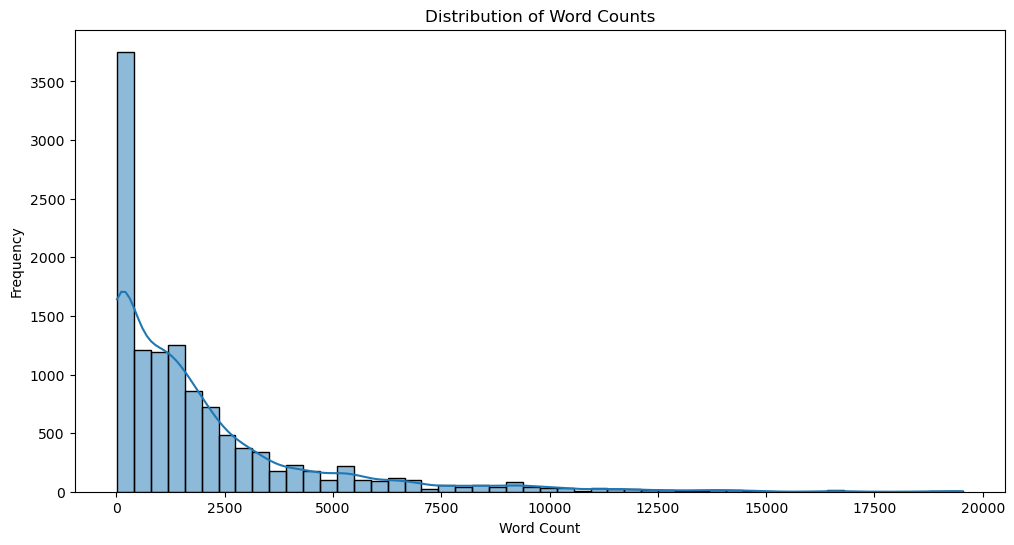

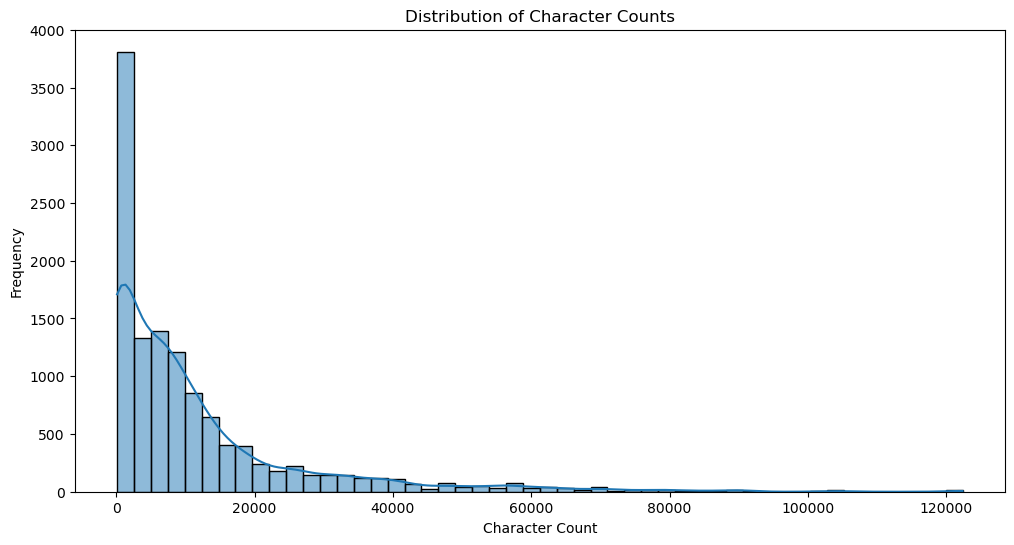

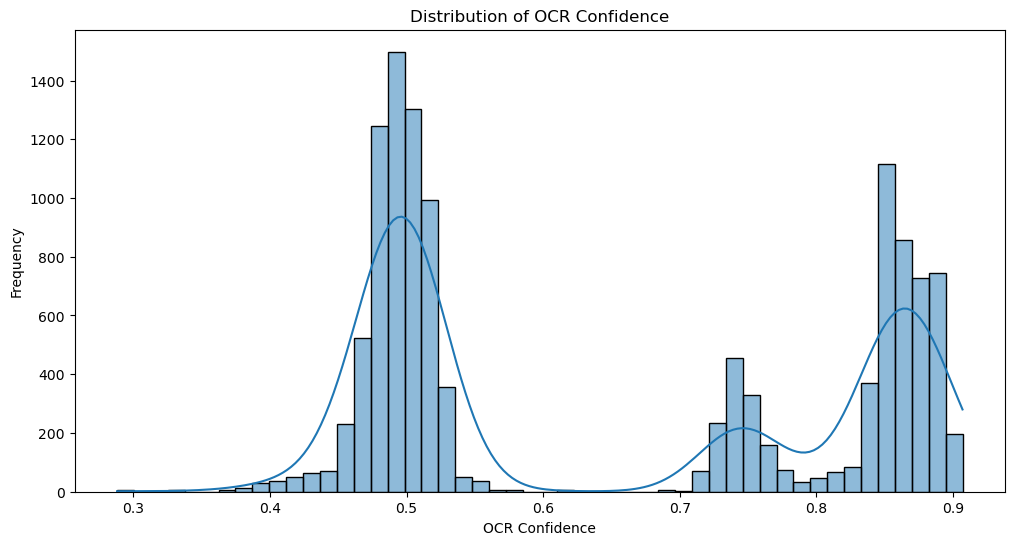

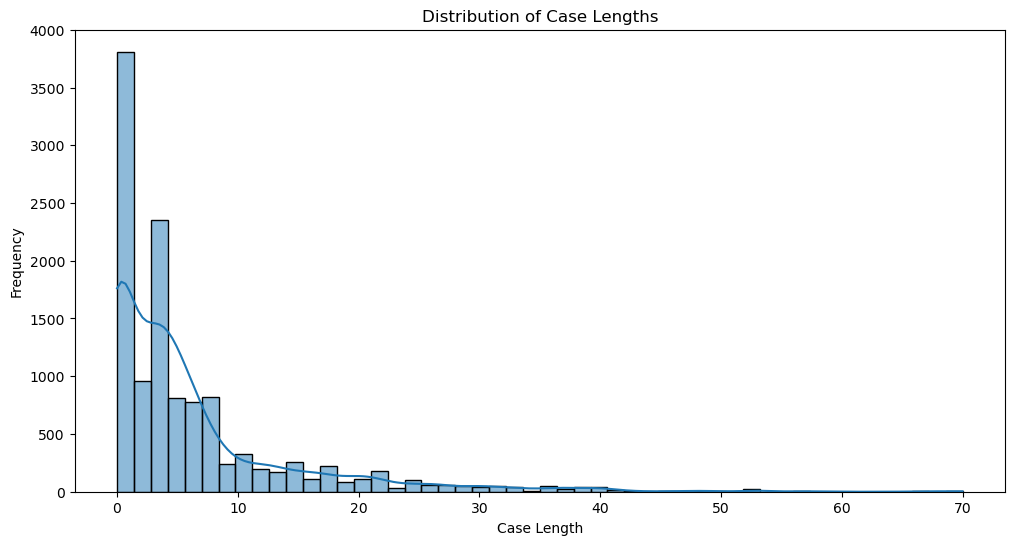

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of word counts
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['analysis.word_count'], bins=50, kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Distribution of character counts
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['analysis.char_count'], bins=50, kde=True)
plt.title('Distribution of Character Counts')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

# Distribution of OCR confidence
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['analysis.ocr_confidence'], bins=50, kde=True)
plt.title('Distribution of OCR Confidence')
plt.xlabel('OCR Confidence')
plt.ylabel('Frequency')
plt.show()

# Distribution of case lengths
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['case_length'], bins=50, kde=True)
plt.title('Distribution of Case Lengths')
plt.xlabel('Case Length')
plt.ylabel('Frequency')
plt.show()


## 3.4.3 Bivariate Analysis<a id='3.4.3'></a>

## a. Relationship Between Word Count and Case Length

Here we can see a clear relationship between word_count and case_length, both are increasing proportionally.

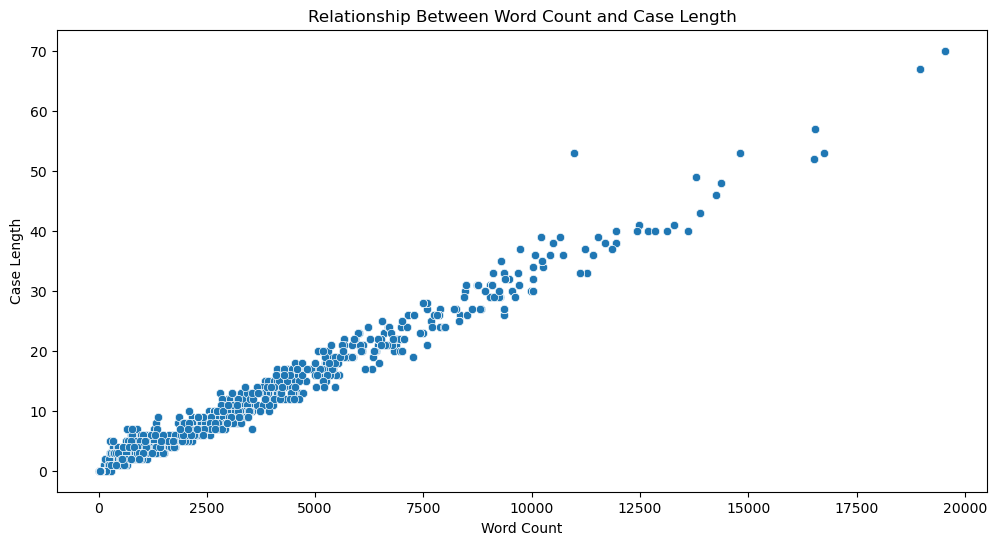

In [31]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scotus_data, x='analysis.word_count', y='case_length')
plt.title('Relationship Between Word Count and Case Length')
plt.xlabel('Word Count')
plt.ylabel('Case Length')
plt.show()


## b. Relationship Between OCR Confidence and Character Count

The scatter plot of character count versus OCR confidence reveals three distinct clusters:

First Cluster: This group, with OCR confidence around 0.5 and character counts between 0 and 20,000, indicates lower OCR accuracy associated with shorter documents or sections.

Second Cluster: Found between 0.7 and 0.8 OCR confidence, this elongated cluster suggests a range of longer documents with higher OCR accuracy, with some outliers having exceptionally high character counts (up to 120,000).

Third Cluster: This cluster, around 0.9 OCR confidence and character counts between 0 and 8,000, represents high OCR accuracy for shorter documents, with a few outliers exhibiting very high character counts (100,000 to 120,000), indicating possible anomalies or special cases in the data.

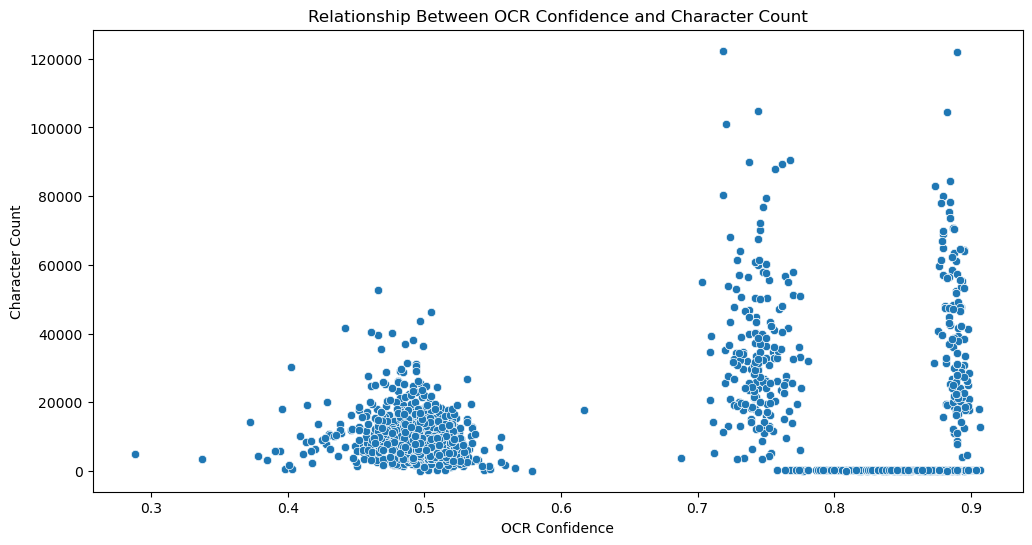

In [32]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scotus_data, x='analysis.ocr_confidence', y='analysis.char_count')
plt.title('Relationship Between OCR Confidence and Character Count')
plt.xlabel('OCR Confidence')
plt.ylabel('Character Count')
plt.show()


## 3.4.4 Correlation Analysis<a id='3.4.4'></a>

## a. Correlation Matrix for Numerical Columns

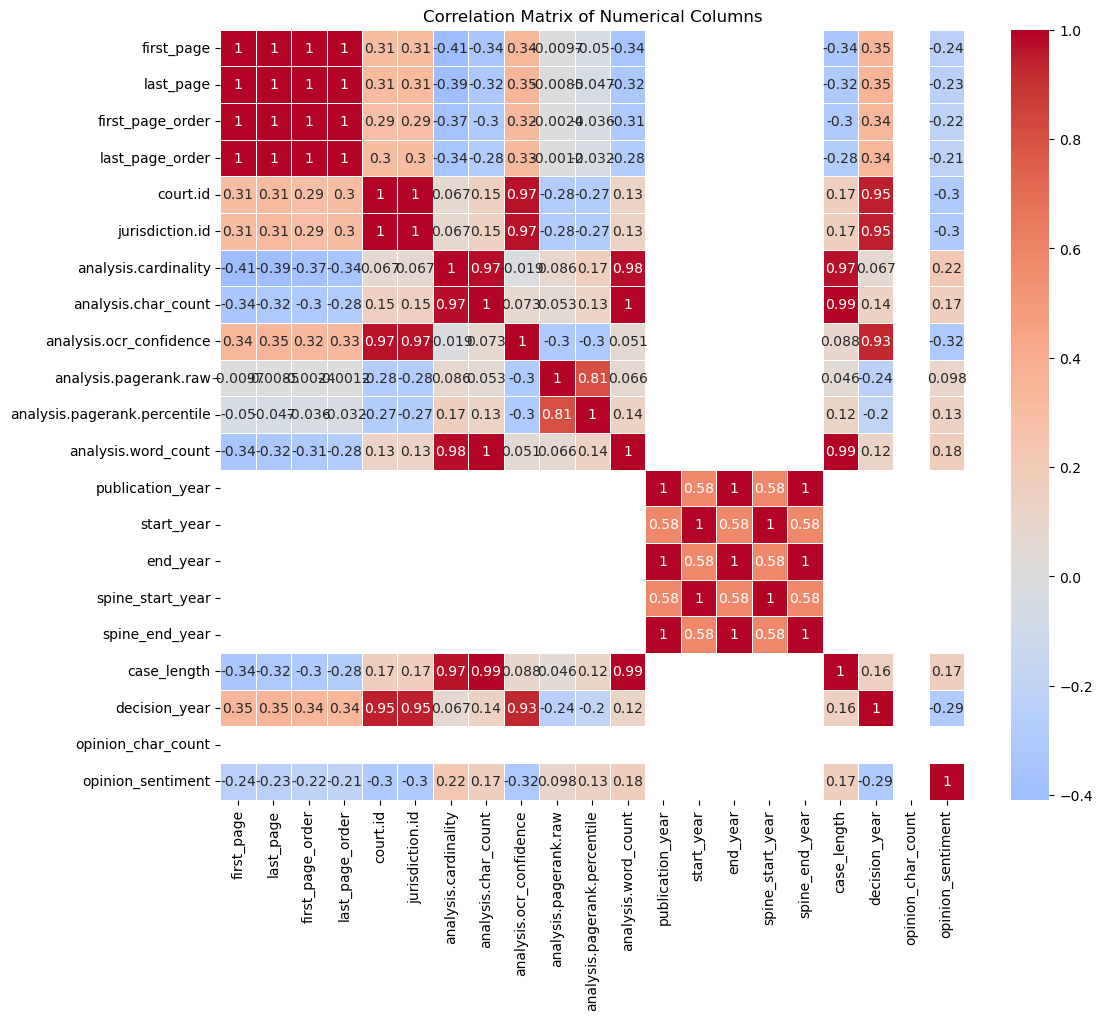

In [33]:
import numpy as np
# Identify numerical columns
numerical_columns = scotus_data.select_dtypes(include=[np.number]).columns

# Calculate the correlation matrix for numerical columns
corr_matrix = scotus_data[numerical_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

## 3.4.5 Temporal Analysis of Case Trends Over Time<a id='3.4.5'></a>

## a. Number of Cases Decided Each Year

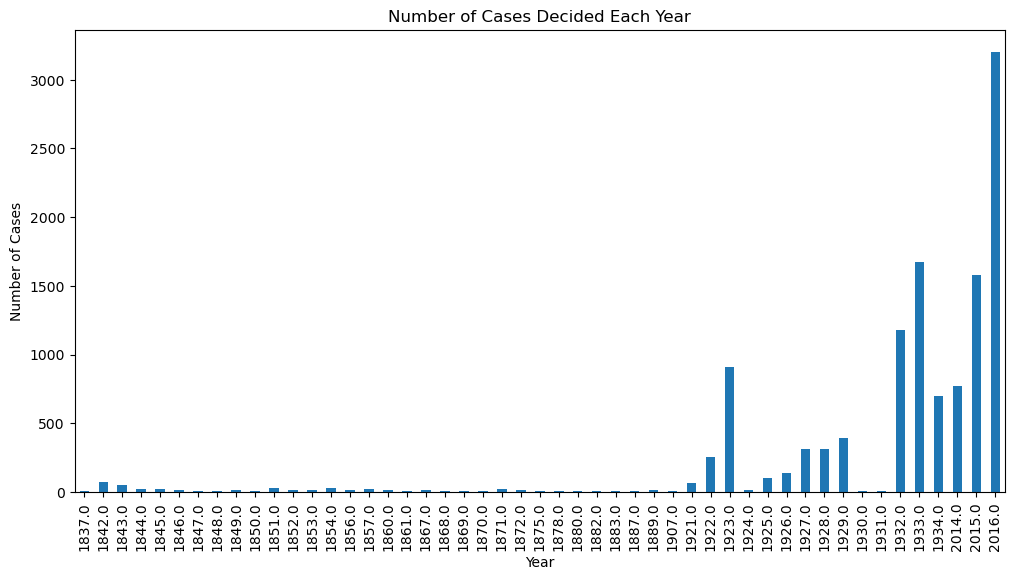

In [34]:
# Convert decision_date to datetime
scotus_data['decision_date'] = pd.to_datetime(scotus_data['decision_date'], errors='coerce')

# Extract year from decision_date
scotus_data['decision_year'] = scotus_data['decision_date'].dt.year

# Count cases per year
cases_per_year = scotus_data['decision_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
cases_per_year.plot(kind='bar')
plt.title('Number of Cases Decided Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.show()


## 3.4.6 Text Analysis<a id='3.4.6'></a>

## a. Word Cloud of Opinions

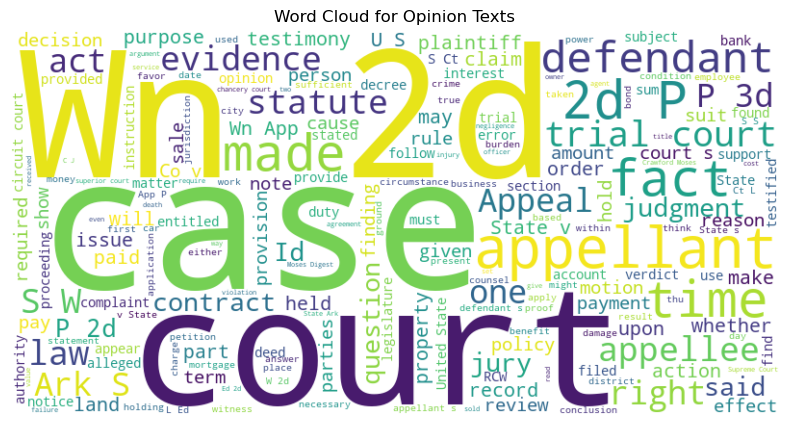

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text data into a single string
text_data = ' '.join(scotus_data['opinion_text'].dropna())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Opinion Texts')
plt.show()


## b. Character Count in Opinions

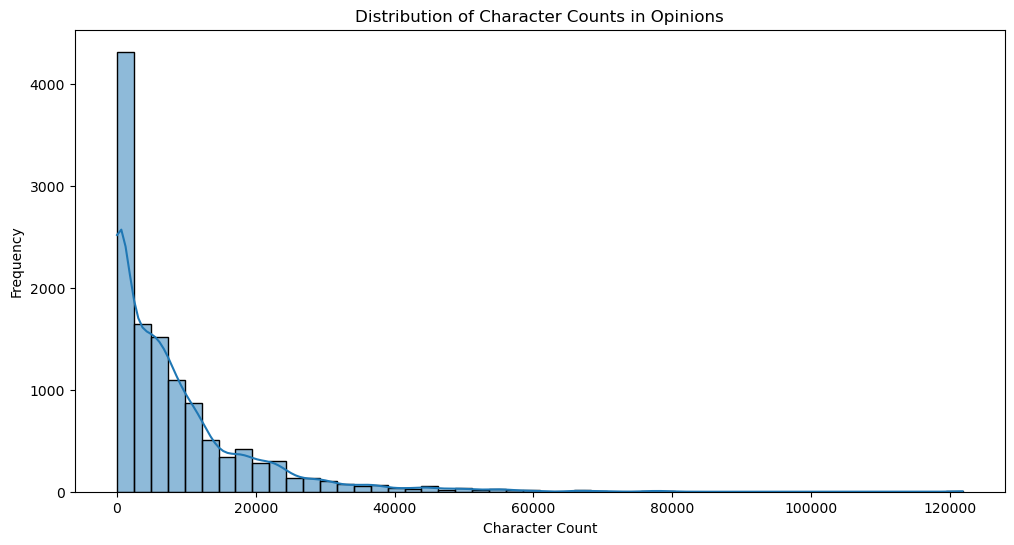

In [36]:


# Function to extract and join text from nested JSON lists
#def extract_text_from_opinion(opinions):
 #   text = ""
   # if isinstance(opinions, list):
  #      for opinion in opinions:
    #        if isinstance(opinion, dict) and 'text' in opinion:
     #           text += ' '.join(opinion['text'])
    #return text

# Apply the function to the column and calculate character count
#scotus_data['opinion_text'] = scotus_data['casebody.opinions'].apply(extract_text_from_opinion)
scotus_data['opinion_char_count'] = scotus_data['opinion_text'].apply(len)

# Plotting the distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['opinion_char_count'], bins=50, kde=True)
plt.title('Distribution of Character Counts in Opinions')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()


## 3.4.7 Case and Court Analysis<a id='3.4.7'></a>

## a. Case Lengths and Citation Counts

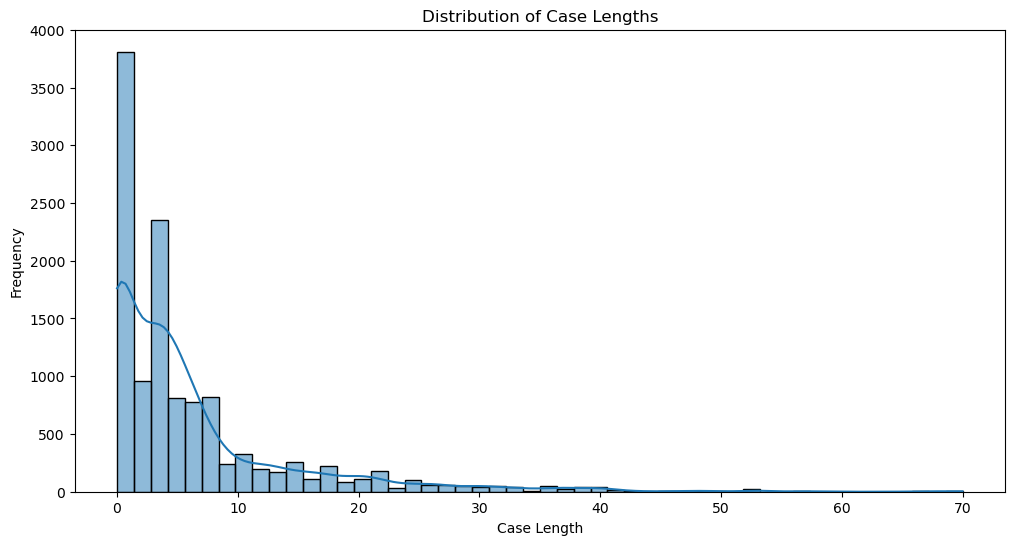

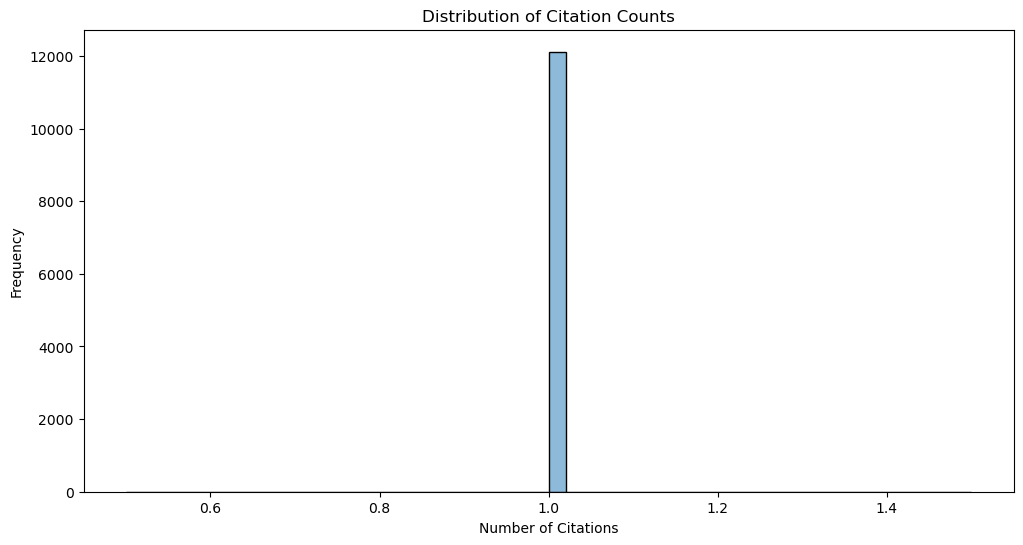

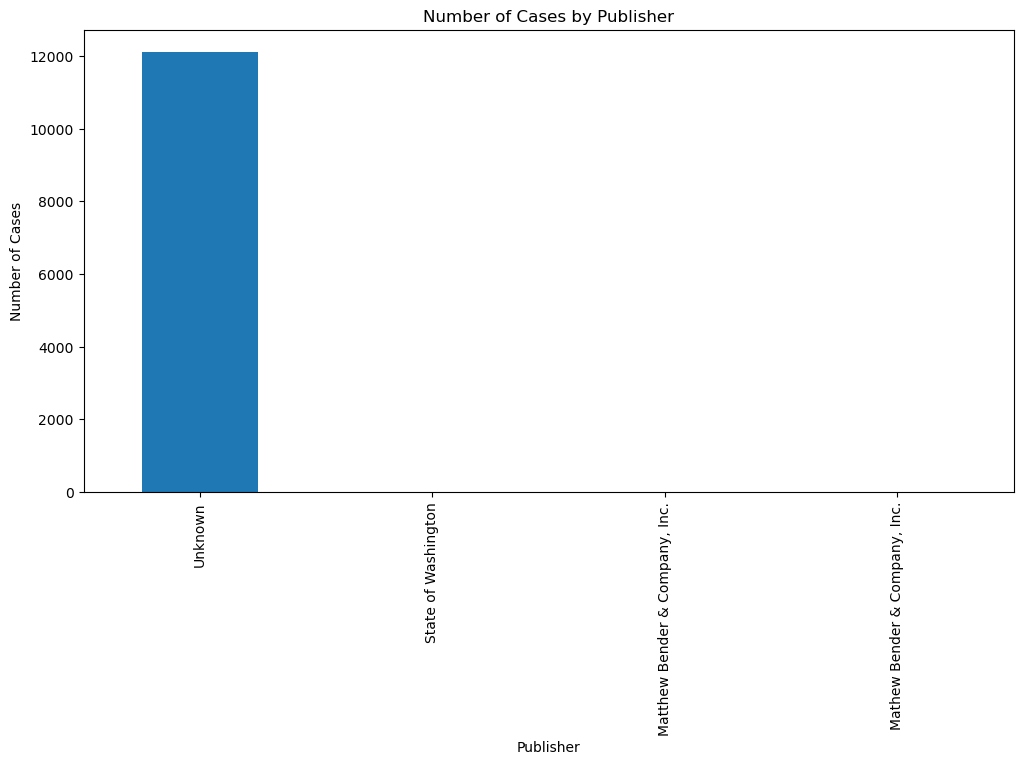

In [37]:
# Case Lengths Distribution
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['case_length'], bins=50, kde=True)
plt.title('Distribution of Case Lengths')
plt.xlabel('Case Length')
plt.ylabel('Frequency')
plt.show()

# Citation Counts Distribution
citation_counts = scotus_data['citations_cite'].apply(lambda x: len(x.split(', ')))
plt.figure(figsize=(12, 6))
sns.histplot(citation_counts, bins=50, kde=True)
plt.title('Distribution of Citation Counts')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.show()

# Analysis of Publishers
publisher_counts = scotus_data['publisher'].value_counts()
plt.figure(figsize=(12, 6))
publisher_counts.plot(kind='bar')
plt.title('Number of Cases by Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Cases')
plt.show()


## b. Court Analysis

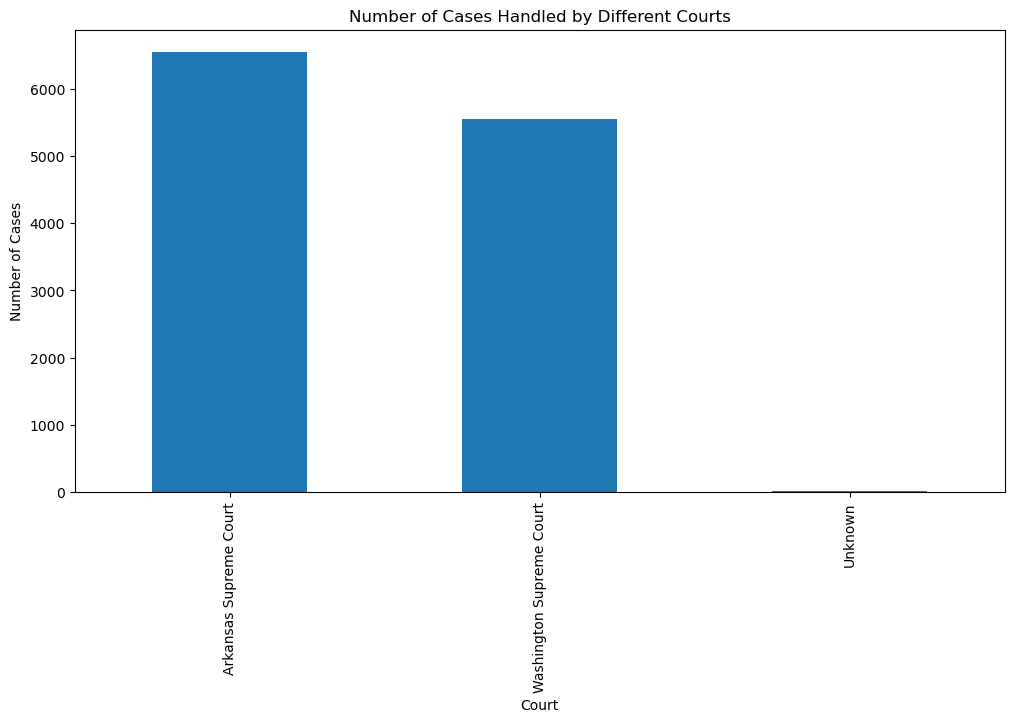

In [38]:
# Count cases per court
cases_per_court = scotus_data['court.name'].value_counts()
plt.figure(figsize=(12, 6))
cases_per_court.plot(kind='bar')
plt.title('Number of Cases Handled by Different Courts')
plt.xlabel('Court')
plt.ylabel('Number of Cases')
plt.show()


## 3.4.8 Network Analysis of Cited Cases - removed <a id='3.4.8'></a>

## a. Create a Citation Network

                     cite                  category        reporter  \
0            116 F.3d 903         reporters:federal            F.3d   
1  325 U.S. App. D.C. 282           reporters:state  U.S. App. D.C.   
2             400 U.S. 74         reporters:federal            U.S.   
3            513 P.2d 831  reporters:state_regional            P.2d   
4            82 Wn.2d 736           reporters:state        Wash. 2d   

              case_ids  weight    year                           pin_cites  \
0  [3706099, 11980710]     2.0  1997.0  [{'page': '912'}, {'page': '913'}]   
1            [3706099]     NaN  1997.0                                 NaN   
2           [12046557]     3.0  1970.0                    [{'page': '86'}]   
3                  NaN     NaN  1973.0                                 NaN   
4            [1130140]     NaN  1973.0                   [{'page': '739'}]   

   opinion_index                                  case_paths  
0              0  [/us-app-dc/325/0282-01

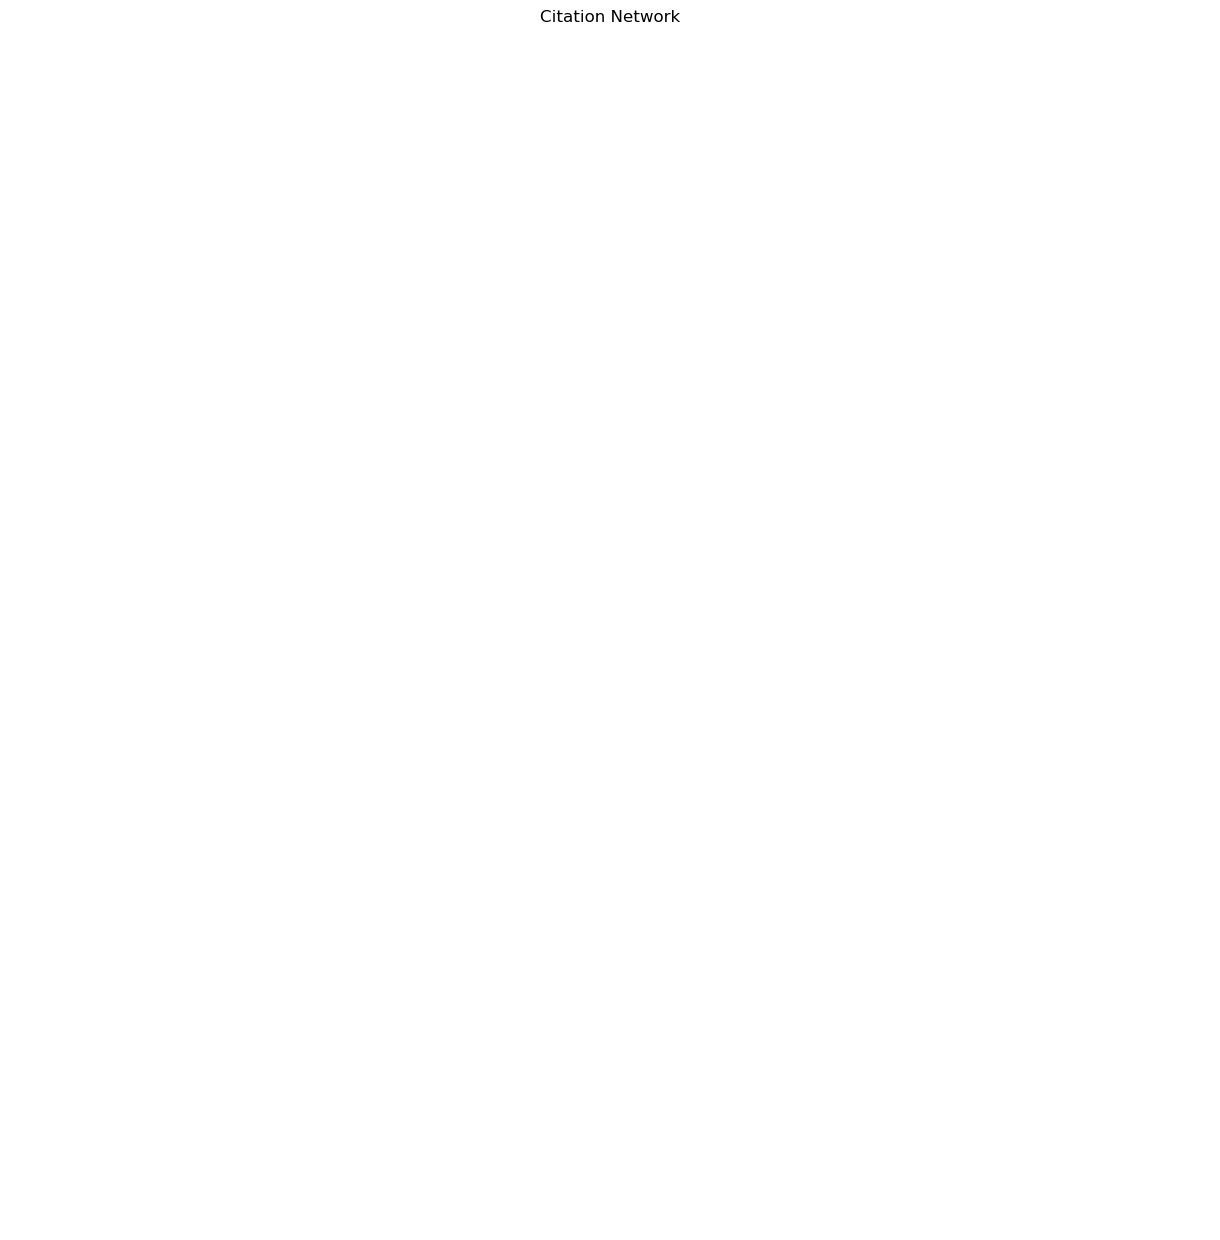

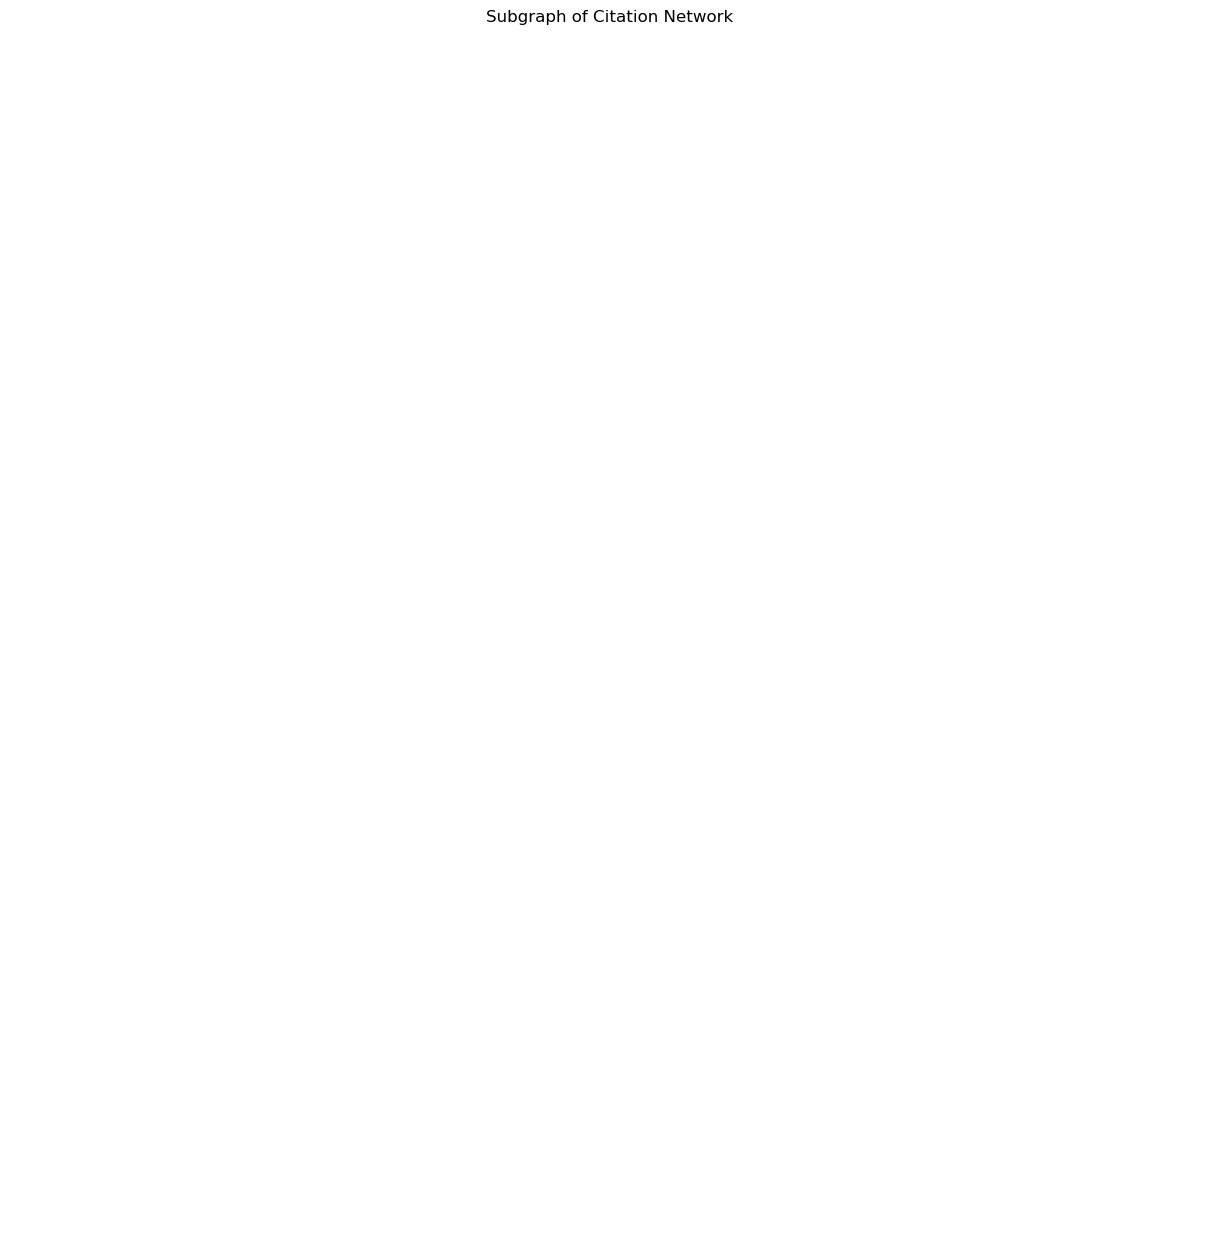

In [61]:
import pandas as pd

# Assuming scotus_data is your main DataFrame

# Define a function to handle the extraction and expansion of 'cites_to'
def expand_cites_to(row):
    cites_to_list = row.get('cites_to', [])
    # Ensure cites_to_list is a list of dictionaries
    if isinstance(cites_to_list, list):
        return pd.DataFrame(cites_to_list)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if not a list

# Apply the function to each row and concatenate the results into a single DataFrame
expanded_cites_to_list = [expand_cites_to(row) for _, row in scotus_data.iterrows()]
cites_to_expanded = pd.concat(expanded_cites_to_list, ignore_index=True)

# Print to check
print(cites_to_expanded.head())


# Check the columns and data types
print(cites_to_expanded.info())

# Check the first few rows to ensure it contains the expected data
print(cites_to_expanded.head())


import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

def add_citations_to_graph(df):
    for _, row in df.iterrows():
        citing_case = row.get('cite', None)  # Adjust based on your actual column name
        cited_cases = row.get('case_ids', [])
        
        if not isinstance(cited_cases, list):
            cited_cases = []  # Default to an empty list if not a list
        
        if citing_case and isinstance(citing_case, str):
            for cited_case in cited_cases:
                if isinstance(cited_case, str) and citing_case != cited_case:
                    G.add_edge(citing_case, cited_case)

# Apply the function to the expanded DataFrame
add_citations_to_graph(cites_to_expanded)

# Print the DataFrame to check the first few rows
print(cites_to_expanded.head())

# Ensure 'case_ids' is a list and handle missing or incorrect types
cites_to_expanded['case_ids'] = cites_to_expanded['case_ids'].apply(lambda x: x if isinstance(x, list) else [])


import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add citations to the graph
add_citations_to_graph(cites_to_expanded)

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=50, node_color='blue', font_size=8, font_color='white', edge_color='gray')
plt.title("Citation Network")
plt.show()
# Limit the number of nodes and edges for visualization
subgraph_nodes = list(G.nodes())[:100]  # Take a subset of nodes
subgraph = G.subgraph(subgraph_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, k=0.5)
nx.draw(subgraph, pos, with_labels=True, node_size=50, node_color='blue', font_size=8, font_color='white', edge_color='gray')
plt.title("Subgraph of Citation Network")
plt.show()


## b. Calculate PageRank and Betweenness Centrality

In [60]:
# Calculate PageRank
pagerank = nx.pagerank(G)

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

# Create DataFrames for PageRank and Betweenness Centrality
pagerank_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['PageRank'])
betweenness_df = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['Betweenness Centrality'])

# Merge with the original DataFrame
network_metrics_df = pd.concat([pagerank_df, betweenness_df], axis=1, join='inner')
print(network_metrics_df.sort_values(by='PageRank', ascending=False).head())
print(network_metrics_df.sort_values(by='Betweenness Centrality', ascending=False).head())


                        PageRank  Betweenness Centrality
3706099                 0.266082                     0.0
12046557                0.216374                     0.0
11980710                0.166667                     0.0
116 F.3d 903            0.116959                     0.0
325 U.S. App. D.C. 282  0.116959                     0.0
                        PageRank  Betweenness Centrality
116 F.3d 903            0.116959                     0.0
3706099                 0.266082                     0.0
11980710                0.166667                     0.0
325 U.S. App. D.C. 282  0.116959                     0.0
400 U.S. 74             0.116959                     0.0


## 3.4.9 Analysis of Judges and Their Opinions<a id='3.4.9'></a>

## a. Frequency of Judges

In [41]:
# Count occurrences of each judge
judge_counts = scotus_data['casebody_judges'].value_counts()
print(judge_counts)

Unknown              3753
Smith, J.             896
Humphreys, J.         798
Butler, J.            532
McHaney, J.           441
                     ... 
Meuaffy, J.             7
Mr. Justice Hanly       7
Macuxn                  7
Mehafey, J.             7
McHaNEy, J.             7
Name: casebody_judges, Length: 151, dtype: int64


## b. Sentiment Analysis of Opinions

In [42]:
from textblob import TextBlob

# Define a function to analyze sentiment
def analyze_sentiment(text):
    try:
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    except Exception as e:
        return None

# Apply sentiment analysis
scotus_data['opinion_sentiment'] = scotus_data['casebody.opinions'].apply(lambda x: analyze_sentiment(json.dumps(x)))
print(scotus_data[['casebody_judges', 'opinion_sentiment']].head())


   casebody_judges  opinion_sentiment
0      Wiggins, J.           0.011637
1    Humphreys, J.          -0.003222
2        Smith, J.           0.045642
3         Wood, J.           0.128645
4  Johnson, C. J.,          -0.020170


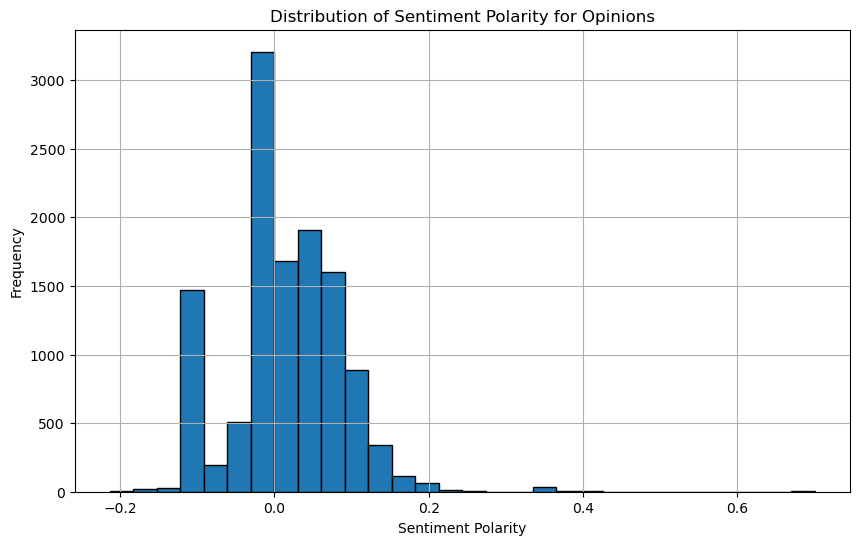

In [43]:
import matplotlib.pyplot as plt

# Drop rows with None or NaN sentiment values
sentiment_data = scotus_data.dropna(subset=['opinion_sentiment'])

# Plot the sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(sentiment_data['opinion_sentiment'], bins=30, edgecolor='black')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity for Opinions')
plt.grid(True)
plt.show()
